# Notebook de treinamento de redes convolucionais com os dados classificados por especialistas

Neste notebook treinamos diversas arquiteturas de redes convolucionais partindo dos pesos da ImageNet. Para este notebook, usamos apenas os dados anotados por especialistas e avaliamos as redes no conjunto de validação.

# Base de dados e importações

In [ ]:
!gdown --id 1lCN31ttToSzd28leuD1B9VbFtTUaWbfU --output dados.zip
!unzip dados.zip
!gdown --id 1wG0iOHehIWF38kEpGhuHfFRotBBMC9t_ --output CSV.zip
!unzip CSV.zip

Streaming output truncated to the last 5000 lines.
  inflating: melspectograma/24f7177c-c147-4ea8-9a9e-6f273d4f6fe4.jpg  
  inflating: melspectograma/9cefcba6-bea1-4131-a905-3d28e567344b.jpg  
  inflating: melspectograma/a4468aa1-4ce9-4965-a8c2-5b1860e1274d.jpg  
  inflating: melspectograma/bc36aed7-62e4-403d-992d-eb186cf2ccc1.jpg  
  inflating: melspectograma/da13dce6-31c9-411d-8ac6-3163892b9f8d.jpg  
  inflating: melspectograma/72418df9-2a0a-4da5-922d-7a1d5d12ab80.jpg  
  inflating: melspectograma/416c24b9-c0cc-4071-b55f-70ed103e02bc.jpg  
  inflating: melspectograma/901961a0-1c48-4a41-b247-1ff7034ed97d.jpg  
  inflating: melspectograma/3c46fbfe-cec8-41b3-9360-9e3e75a784de.jpg  
  inflating: melspectograma/21fc5063-f772-45be-992a-7af2b977ab12.jpg  
  inflating: melspectograma/3ba36da8-a4af-4dce-ad62-d3398d4c9cd5.jpg  
  inflating: melspectograma/5157deaa-f5f3-4a49-97ef-cd7ae396d446.jpg  
  inflating: melspectograma/70e16d99-c4b2-4d6b-a7c2-8d6b7e8fe68a.jpg  
  inflating: melspectogram

In [ ]:
import pandas as pd
from collections import Counter
import tensorflow as tf
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline

Foi efetuado o mapeamento das classes que até então era string categórico, para os valores 0, 1 e 2.

*   healthy - 0 
*   symptomatic -  1 
*   COVID-19 - 2

In [ ]:
train = pd.read_csv('/content/CSV/train.csv')
val = pd.read_csv('/content/CSV/val.csv')
train['classInt'] = train['status'].replace(['healthy','symptomatic','COVID-19'], [0, 1, 2])
val['classInt'] = val['status'].replace(['healthy','symptomatic','COVID-19'], [0, 1, 2])
train['classStr'] = train['classInt'].astype('str')
val['classStr'] = val['classInt'].astype('str')
train['uuid'] = train['uuid'] + '.jpg'
val['uuid'] = val['uuid'] + '.jpg'

Utilizou-se os pesos para cada classe como forma de lidar com o desbalanceamento dos dados.

Ficando dessa forma:

*   healthy -  representado pelo 0 - ficou com o peso 1.3982300884955752
*   symptomatic -  represenatado pelo 1 - ficou com o peso 1.0 
*   COVID-19 - represenatado pelo 2 - ficou com o peso 1.5906040268456376

In [ ]:
# Determinando os pesos
counter = Counter(train['classInt'])  
max_val = float(max(counter.values()))  
class_weights = {class_id : max_val/num_images for class_id, num_images in counter.items()}    
class_weights 

{0: 1.3982300884955752, 1: 1.0, 2: 1.5906040268456376}

# Função para treinamento de modelos

Como foi analisado que a execução de uma época da rede dura poucos segundos iremos testar a base com esse pré-processamento em 21 redes diferentes da imagenet para ver qual obteve a melhor acurácia tornando-a por fim o nosso baseline inicial. As redes a serem analisadas são listadas abaixo:

ResNet50
ResNet101	
ResNet152	
EfficientNetB0
EfficientNetB1
EfficientNetB2
EfficientNetB3
EfficientNetB4
EfficientNetB5	
EfficientNetB6	
EfficientNetB7	
MobileNet	
MobileNetV2	
DenseNet121	
DenseNet169	
DenseNet201	
InceptionV3	
InceptionResNetV2	
Xception	
VGG16	
VGG19	

In [ ]:
def cria_e_treina_rede(model_name, train_df, val_df, batch_size=32, callbacks=[], image_size=(256, 256), pooling='avg', loss='categorical_crossentropy', optimizer='adam', epochs=50, class_weights=class_weights, trainable=True):

  if model_name == 'resnet50' or model_name == 'resnet101' or model_name == 'resnet152':
    preprocessing_function = tf.keras.applications.resnet.preprocess_input
  elif model_name == 'efficientnetb0' or model_name == 'efficientnetb1' or model_name == 'efficientnetb2' or model_name == 'efficientnetb3' or model_name == 'efficientnetb4' or model_name == 'efficientnetb5'  or model_name == 'efficientnetb6' or model_name == 'efficientnetb7':
    preprocessing_function = tf.keras.applications.efficientnet.preprocess_input
  elif model_name == 'mobilenet':
    preprocessing_function = tf.keras.applications.mobilenet.preprocess_input
  elif model_name == 'mobilenetv2':
    preprocessing_function = tf.keras.applications.mobilenet_v2.preprocess_input
  elif model_name == 'densenet121' or model_name == 'densenet169' or model_name == 'densenet201':
    preprocessing_function = tf.keras.applications.densenet.preprocess_input
  elif model_name == 'inceptionv3':
    preprocessing_function = tf.keras.applications.inception_v3.preprocess_input
  elif model_name == 'inceptionresnetv2':
    preprocessing_function = tf.keras.applications.inception_resnet_v2.preprocess_input
  elif model_name == 'xception':
    preprocessing_function = tf.keras.applications.xception.preprocess_input
  elif model_name == 'vgg16':
    preprocessing_function = tf.keras.applications.vgg16.preprocess_input
  elif model_name == 'vgg19':
    preprocessing_function = tf.keras.applications.vgg19.preprocess_input

  datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=preprocessing_function,
  )

  train_generator = datagen.flow_from_dataframe(
    train_df, directory='/content/melspectograma', x_col='uuid', y_col='classStr',
    target_size=image_size, class_mode='categorical', batch_size=batch_size, shuffle=True, seed=42, color_mode='rgb')

  val_generator = datagen.flow_from_dataframe(
    val_df, directory='/content/melspectograma', x_col='uuid', y_col='classStr',
    target_size=image_size, class_mode='categorical', batch_size=batch_size, shuffle=False, seed=42, color_mode='rgb')
  
  if model_name == 'resnet50':
    pre_trained = tf.keras.applications.ResNet50(include_top=False, pooling=pooling)
  elif model_name == 'resnet101':
    pre_trained = tf.keras.applications.ResNet101(include_top=False, pooling=pooling)
  elif model_name == 'resnet152':
    pre_trained = tf.keras.applications.ResNet152(include_top=False, pooling=pooling)
  elif model_name == 'efficientnetb0':
    pre_trained = tf.keras.applications.EfficientNetB0(include_top=False, pooling=pooling)
  elif model_name == 'efficientnetb1':
    pre_trained = tf.keras.applications.EfficientNetB1(include_top=False, pooling=pooling)
  elif model_name == 'efficientnetb2':
    pre_trained = tf.keras.applications.EfficientNetB2(include_top=False, pooling=pooling)
  elif model_name == 'efficientnetb3':
    pre_trained = tf.keras.applications.EfficientNetB3(include_top=False, pooling=pooling)
  elif model_name == 'efficientnetb4':
    pre_trained = tf.keras.applications.EfficientNetB4(include_top=False, pooling=pooling)
  elif model_name == 'efficientnetb5':
    pre_trained = tf.keras.applications.EfficientNetB5(include_top=False, pooling=pooling)
  elif model_name == 'efficientnetb6':
    pre_trained = tf.keras.applications.EfficientNetB6(include_top=False, pooling=pooling)
  elif model_name == 'efficientnetb7':
    pre_trained = tf.keras.applications.EfficientNetB7(include_top=False, pooling=pooling)
  elif model_name == 'mobilenet':
    pre_trained = tf.keras.applications.MobileNet(include_top=False, pooling=pooling)
  elif model_name == 'mobilenetv2':
    pre_trained = tf.keras.applications.MobileNetV2(include_top=False, pooling=pooling)
  elif model_name == 'densenet121':
    pre_trained = tf.keras.applications.DenseNet121(include_top=False, pooling=pooling)
  elif model_name == 'densenet169':
    pre_trained = tf.keras.applications.DenseNet169(include_top=False, pooling=pooling)
  elif model_name == 'densenet201':
    pre_trained = tf.keras.applications.DenseNet201(include_top=False, pooling=pooling)
  elif model_name == 'inceptionv3':
    pre_trained = tf.keras.applications.InceptionV3(include_top=False, pooling=pooling)
  elif model_name == 'inceptionresnetv2':
    pre_trained = tf.keras.applications.InceptionResNetV2(include_top=False, pooling=pooling)
  elif model_name == 'xception':
    pre_trained = tf.keras.applications.Xception(include_top=False, pooling=pooling)
  elif model_name == 'vgg16':
    pre_trained = tf.keras.applications.VGG16(include_top=False, pooling=pooling)
  elif model_name == 'vgg19':
    pre_trained = tf.keras.applications.VGG19(include_top=False, pooling=pooling)

  for layer in pre_trained.layers:
    layer.treinable = trainable

  model = tf.keras.models.Sequential([
   pre_trained,
   tf.keras.layers.Dense(3, activation='softmax')
  ])

  model.summary()

  model.compile(loss=loss, optimizer=optimizer, metrics=['acc'])

  list_of_callbacks = []
  if 'earlystopping' in callbacks:
    list_of_callbacks.append(tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, mode="min", restore_best_weights=True, verbose=1))
  if 'reducelr' in callbacks:
    list_of_callbacks.append(tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=5, mode="min", verbose=1))
  if 'checkpoint' in callbacks:
    list_of_callbacks.append(tf.keras.callbacks.ModelCheckpoint('/content/' + model_name + '.hdf5', save_best_only=True, verbose=1))

  history = model.fit(train_generator, validation_data=val_generator, batch_size=batch_size, class_weight=class_weights, callbacks=list_of_callbacks, epochs=epochs)

  plt.plot(history.history['acc'])
  plt.plot(history.history['val_acc'])
  plt.title(model_name + ' accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'validation'], loc='upper left')
  plt.show()

  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title(model_name + ' loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'validation'], loc='upper left')
  plt.show()

  predict_val = model.predict(val_generator, verbose=1)
  y_true = []

  i = 0
  for batch, label in val_generator:
    i += batch.shape[0]
    for l in np.argmax(label, axis=1):
      y_true.append(l)
    if i == len(val_df): break

  y_true = np.array(y_true)

  print(confusion_matrix(y_true, np.argmax(predict_val, axis=1)))

  cm = confusion_matrix(y_true, np.argmax(predict_val, axis=1))
  cm = cm / cm.astype(np.float).sum(axis=1, keepdims=True)
  balanced_acc = np.trace(cm) / 3
  print('Acuracia balanceada na validacao:', balanced_acc)

  return model

# Modelos

Found 1111 validated image filenames belonging to 3 classes.
Found 278 validated image filenames belonging to 3 classes.
94773248/94765736 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 2048)              23587712  
_________________________________________________________________
dense (Dense)                (None, 3)                 6147      
Total params: 23,593,859
Trainable params: 23,540,739
Non-trainable params: 53,120
_________________________________________________________________
Epoch 1/50
35/35 [==============================] - 58s 544ms/step - loss: 2.3171 - acc: 0.3501 - val_loss: 18.2738 - val_acc: 0.2986
Epoch 2/50
35/35 [==============================] - 16s 446ms/step - loss: 1.4337 - acc: 0.3598 - val_loss: 4.6666 - val_acc: 0.3849
Epoch 3/50
35/35 [==============================

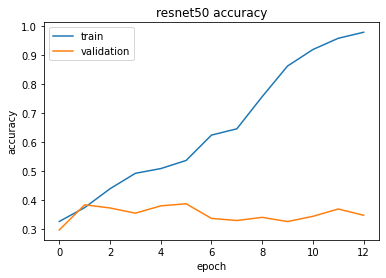

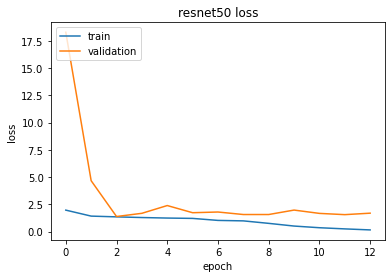

9/9 [==============================] - 2s 141ms/step
[[ 5 82  1]
 [ 5 99  3]
 [ 3 80  0]]
Acuracia balanceada na validacao: 0.32735060889266493


In [ ]:
cria_e_treina_rede('resnet50', train, val, callbacks=['earlystopping', 'reducelr'])

Found 1111 validated image filenames belonging to 3 classes.
Found 278 validated image filenames belonging to 3 classes.
171450368/171446536 [==============================] - 2s 0us/step
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet101 (Functional)       (None, 2048)              42658176  
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 6147      
Total params: 42,664,323
Trainable params: 42,558,979
Non-trainable params: 105,344
_________________________________________________________________
Epoch 1/50
35/35 [==============================] - 39s 837ms/step - loss: 2.2194 - acc: 0.3301 - val_loss: 322590.6562 - val_acc: 0.3849
Epoch 2/50
35/35 [==============================] - 28s 786ms/step - loss: 1.4411 - acc: 0.3423 - val_loss: 2.3425 - val_acc: 0.2986
Epoch 3/50
35/35 [=====================

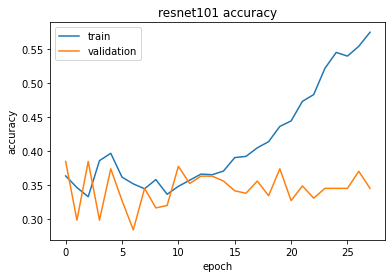

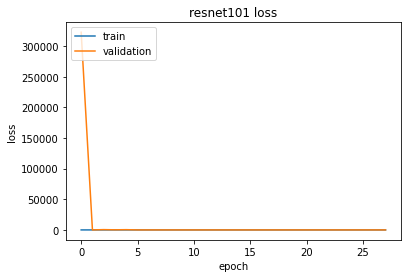

9/9 [==============================] - 3s 245ms/step
[[ 5 11 72]
 [ 3 20 84]
 [ 3  6 74]]
Acuracia balanceada na validacao: 0.37843344490963005


In [ ]:
cria_e_treina_rede('resnet101', train, val, callbacks=['earlystopping', 'reducelr'])

Found 1111 validated image filenames belonging to 3 classes.
Found 278 validated image filenames belonging to 3 classes.
234700800/234698864 [==============================] - 2s 0us/step
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet152 (Functional)       (None, 2048)              58370944  
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 6147      
Total params: 58,377,091
Trainable params: 58,225,667
Non-trainable params: 151,424
_________________________________________________________________
Epoch 1/50
35/35 [==============================] - 56s 1s/step - loss: 2.1536 - acc: 0.3294 - val_loss: 288441.4062 - val_acc: 0.3849
Epoch 2/50
35/35 [==============================] - 39s 1s/step - loss: 1.4391 - acc: 0.3651 - val_loss: 38.1226 - val_acc: 0.3022
Epoch 3/50
35/35 [==========================

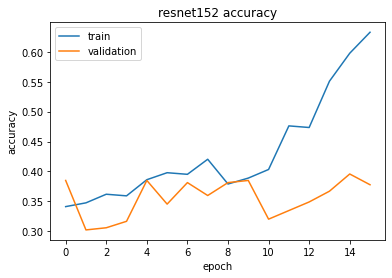

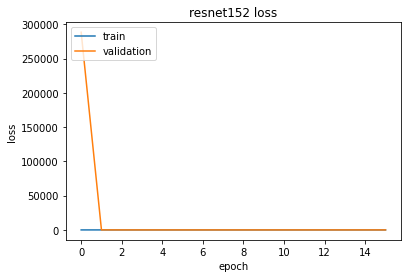

9/9 [==============================] - 5s 356ms/step
[[29  0 59]
 [48  0 59]
 [16  0 67]]
Acuracia balanceada na validacao: 0.3789247900693684


In [ ]:
cria_e_treina_rede('resnet152', train, val, callbacks=['earlystopping', 'reducelr'])

Found 1111 validated image filenames belonging to 3 classes.
Found 278 validated image filenames belonging to 3 classes.
16711680/16705208 [==============================] - 0s 0us/step
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb0 (Functional)  (None, 1280)              4049571   
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 3843      
Total params: 4,053,414
Trainable params: 4,011,391
Non-trainable params: 42,023
_________________________________________________________________
Epoch 1/50
35/35 [==============================] - 26s 507ms/step - loss: 1.5018 - acc: 0.3406 - val_loss: 1.1182 - val_acc: 0.3669
Epoch 2/50
35/35 [==============================] - 15s 428ms/step - loss: 1.2324 - acc: 0.5233 - val_loss: 1.1436 - val_acc: 0.3993
Epoch 3/50
35/35 [==============================]

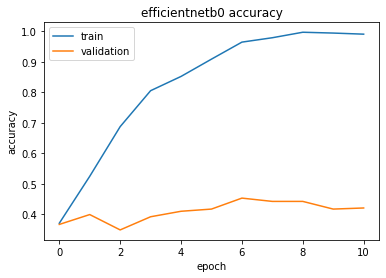

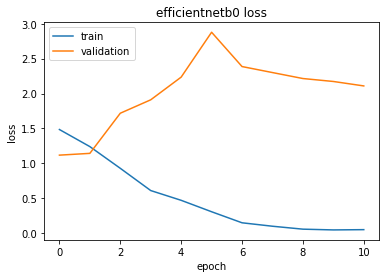

9/9 [==============================] - 2s 80ms/step
[[24  9 55]
 [36 21 50]
 [17  9 57]]
Acuracia balanceada na validacao: 0.38524531430735687


In [ ]:
cria_e_treina_rede('efficientnetb0', train, val, callbacks=['earlystopping', 'reducelr'])

Found 1111 validated image filenames belonging to 3 classes.
Found 278 validated image filenames belonging to 3 classes.
27025408/27018416 [==============================] - 29s 1us/step
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb1 (Functional)  (None, 1280)              6575239   
_________________________________________________________________
dense_4 (Dense)              (None, 3)                 3843      
Total params: 6,579,082
Trainable params: 6,517,027
Non-trainable params: 62,055
_________________________________________________________________
Epoch 1/50
35/35 [==============================] - 34s 664ms/step - loss: 1.5065 - acc: 0.3574 - val_loss: 1.1519 - val_acc: 0.3633
Epoch 2/50
35/35 [==============================] - 21s 606ms/step - loss: 1.2215 - acc: 0.5159 - val_loss: 1.1474 - val_acc: 0.3741
Epoch 3/50
35/35 [==============================

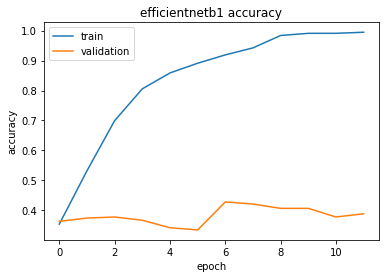

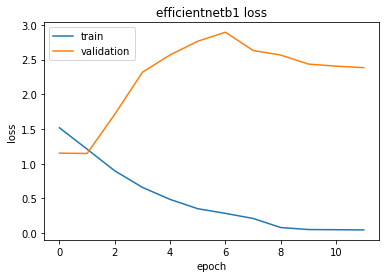

9/9 [==============================] - 2s 111ms/step
[[10 31 47]
 [10 51 46]
 [11 29 43]]
Acuracia balanceada na validacao: 0.3694480556038939


In [ ]:
cria_e_treina_rede('efficientnetb1', train, val, callbacks=['earlystopping', 'reducelr'])

Found 1111 validated image filenames belonging to 3 classes.
Found 278 validated image filenames belonging to 3 classes.
31793152/31790344 [==============================] - 0s 0us/step
Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb2 (Functional)  (None, 1408)              7768569   
_________________________________________________________________
dense_5 (Dense)              (None, 3)                 4227      
Total params: 7,772,796
Trainable params: 7,705,221
Non-trainable params: 67,575
_________________________________________________________________
Epoch 1/50
35/35 [==============================] - 36s 731ms/step - loss: 1.5363 - acc: 0.3597 - val_loss: 1.3270 - val_acc: 0.3237
Epoch 2/50
35/35 [==============================] - 22s 635ms/step - loss: 1.2205 - acc: 0.5303 - val_loss: 2.0343 - val_acc: 0.3165
Epoch 3/50
35/35 [==============================]

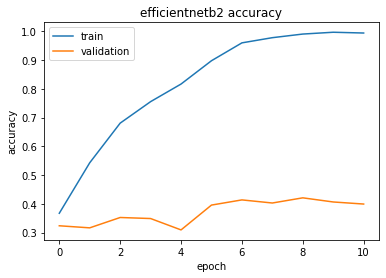

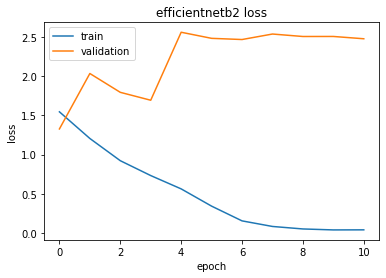

9/9 [==============================] - 3s 117ms/step
[[74 14  0]
 [91 16  0]
 [68 15  0]]
Acuracia balanceada na validacao: 0.33014726706315495


In [ ]:
cria_e_treina_rede('efficientnetb2', train, val, callbacks=['earlystopping', 'reducelr'])

Found 1111 validated image filenames belonging to 3 classes.
Found 278 validated image filenames belonging to 3 classes.
43941888/43941136 [==============================] - 0s 0us/step
Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb3 (Functional)  (None, 1536)              10783535  
_________________________________________________________________
dense_6 (Dense)              (None, 3)                 4611      
Total params: 10,788,146
Trainable params: 10,700,843
Non-trainable params: 87,303
_________________________________________________________________
Epoch 1/50
35/35 [==============================] - 46s 928ms/step - loss: 1.5571 - acc: 0.3845 - val_loss: 1.2437 - val_acc: 0.3022
Epoch 2/50
35/35 [==============================] - 28s 800ms/step - loss: 1.2043 - acc: 0.5483 - val_loss: 1.1387 - val_acc: 0.3777
Epoch 3/50
35/35 [=============================

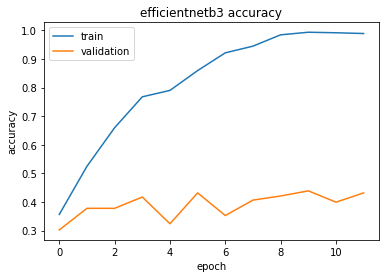

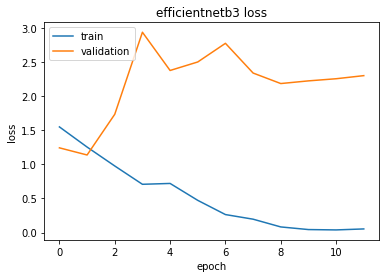

9/9 [==============================] - 3s 153ms/step
[[56 19 13]
 [63 28 16]
 [52 10 21]]
Acuracia balanceada na validacao: 0.38368597584902053


In [ ]:
cria_e_treina_rede('efficientnetb3', train, val, callbacks=['earlystopping', 'reducelr'])

Found 1111 validated image filenames belonging to 3 classes.
Found 278 validated image filenames belonging to 3 classes.
71688192/71686520 [==============================] - 2s 0us/step
Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb4 (Functional)  (None, 1792)              17673823  
_________________________________________________________________
dense_7 (Dense)              (None, 3)                 5379      
Total params: 17,679,202
Trainable params: 17,553,995
Non-trainable params: 125,207
_________________________________________________________________
Epoch 1/50
35/35 [==============================] - 56s 1s/step - loss: 1.5408 - acc: 0.3581 - val_loss: 1.2215 - val_acc: 0.3489
Epoch 2/50
35/35 [==============================] - 36s 1s/step - loss: 1.1553 - acc: 0.5831 - val_loss: 1.6364 - val_acc: 0.3309
Epoch 3/50
35/35 [==============================] - 

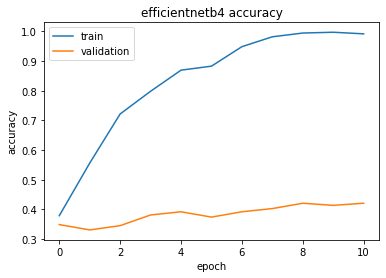

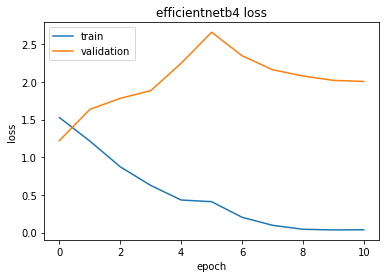

9/9 [==============================] - 4s 199ms/step
[[32  2 54]
 [37  4 66]
 [22  0 61]]
Acuracia balanceada na validacao: 0.3786531000808672


In [ ]:
cria_e_treina_rede('efficientnetb4', train, val, callbacks=['earlystopping', 'reducelr'])

Found 1111 validated image filenames belonging to 3 classes.
Found 278 validated image filenames belonging to 3 classes.
115269632/115263384 [==============================] - 2s 0us/step
Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb5 (Functional)  (None, 2048)              28513527  
_________________________________________________________________
dense_8 (Dense)              (None, 3)                 6147      
Total params: 28,519,674
Trainable params: 28,346,931
Non-trainable params: 172,743
_________________________________________________________________
Epoch 1/50
70/70 [==============================] - 77s 818ms/step - loss: 1.6062 - acc: 0.3499 - val_loss: 1.4138 - val_acc: 0.3885
Epoch 2/50
70/70 [==============================] - 51s 726ms/step - loss: 1.3113 - acc: 0.4508 - val_loss: 1.2535 - val_acc: 0.3165
Epoch 3/50
70/70 [==========================

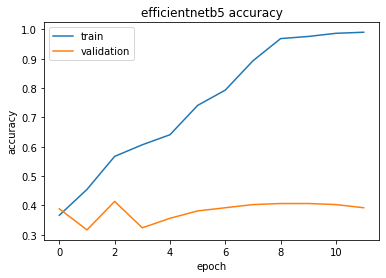

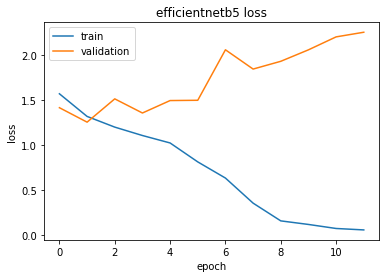

18/18 [==============================] - 5s 135ms/step
[[10  9 69]
 [19 17 71]
 [19  3 61]]
Acuracia balanceada na validacao: 0.33581820911513516


In [ ]:
cria_e_treina_rede('efficientnetb5', train, val, callbacks=['earlystopping', 'reducelr'], batch_size=16)

Found 1111 validated image filenames belonging to 3 classes.
Found 278 validated image filenames belonging to 3 classes.
165240832/165234480 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb6 (Functional)  (None, 2304)              40960143  
_________________________________________________________________
dense (Dense)                (None, 3)                 6915      
Total params: 40,967,058
Trainable params: 40,742,619
Non-trainable params: 224,439
_________________________________________________________________
Epoch 1/50
70/70 [==============================] - 124s 991ms/step - loss: 1.6273 - acc: 0.3419 - val_loss: 1.5607 - val_acc: 0.3237
Epoch 2/50
70/70 [==============================] - 63s 905ms/step - loss: 1.2952 - acc: 0.4783 - val_loss: 1.1345 - val_acc: 0.3417
Epoch 3/50
70/70 [===========================

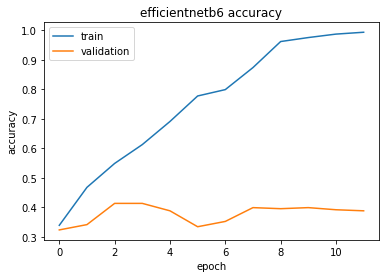

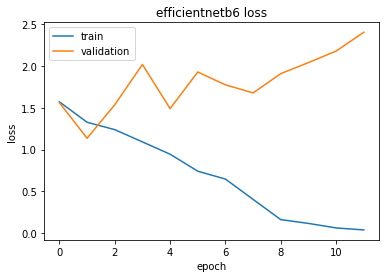

18/18 [==============================] - 6s 174ms/step
[[37 35 16]
 [47 40 20]
 [36 29 18]]
Acuracia balanceada na validacao: 0.3370512636783327


In [ ]:
cria_e_treina_rede('efficientnetb6', train, val, callbacks=['earlystopping', 'reducelr'], batch_size=16)

Found 1111 validated image filenames belonging to 3 classes.
Found 278 validated image filenames belonging to 3 classes.
258080768/258076736 [==============================] - 3s 0us/step
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb7 (Functional)  (None, 2560)              64097687  
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 7683      
Total params: 64,105,370
Trainable params: 63,794,643
Non-trainable params: 310,727
_________________________________________________________________
Epoch 1/50
139/139 [==============================] - 126s 705ms/step - loss: 1.7095 - acc: 0.3710 - val_loss: 1.1036 - val_acc: 0.3417
Epoch 2/50
139/139 [==============================] - 91s 656ms/step - loss: 1.4153 - acc: 0.3957 - val_loss: 1.1476 - val_acc: 0.3669
Epoch 3/50
139/139 [===================

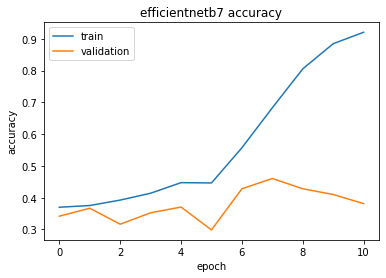

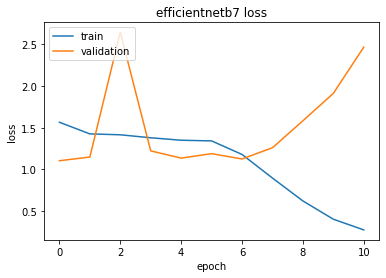

35/35 [==============================] - 8s 127ms/step
[[12 21 55]
 [ 6 32 69]
 [12 20 51]]
Acuracia balanceada na validacao: 0.34996229608322843


In [ ]:
cria_e_treina_rede('efficientnetb7', train, val, callbacks=['earlystopping', 'reducelr'], batch_size=8)

Found 1111 validated image filenames belonging to 3 classes.
Found 278 validated image filenames belonging to 3 classes.
17227776/17225924 [==============================] - 0s 0us/step
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenet_1.00_224 (Function (None, 1024)              3228864   
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 3075      
Total params: 3,231,939
Trainable params: 3,210,051
Non-trainable params: 21,888
_________________________________________________________________
Epoch 1/50
35/35 [==============================] - 14s 315ms/step - loss: 2.1231 - acc: 0.3566 - val_loss: 2.6267 - val_acc: 0.3165
Epoch 2/50
35/35 [==============================] - 9s 267ms/step - loss: 1.3981 - acc: 0.4985 - val_loss: 2.4469 - val_acc: 0.3705
Epoch 3/50
35/35 [==============================] 

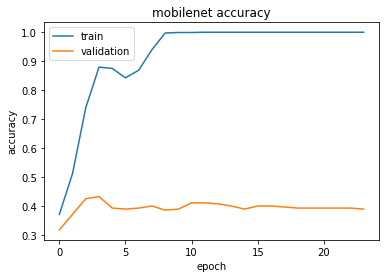

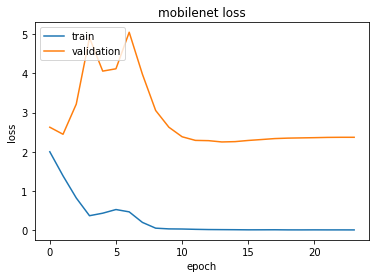

9/9 [==============================] - 1s 74ms/step
[[23 49 16]
 [24 64 19]
 [26 33 24]]
Acuracia balanceada na validacao: 0.38288370133038524


In [ ]:
cria_e_treina_rede('mobilenet', train, val, callbacks=['earlystopping', 'reducelr'])

Found 1111 validated image filenames belonging to 3 classes.
Found 278 validated image filenames belonging to 3 classes.
9412608/9406464 [==============================] - 0s 0us/step
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 1280)              2257984   
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 3843      
Total params: 2,261,827
Trainable params: 2,227,715
Non-trainable params: 34,112
_________________________________________________________________
Epoch 1/50
35/35 [==============================] - 17s 337ms/step - loss: 1.7010 - acc: 0.3710 - val_loss: 5.4883 - val_acc: 0.2986
Epoch 2/50
35/35 [==============================] - 10s 278ms/step - loss: 1.3277 - acc: 0.4432 - val_loss: 5.5577 - val_acc: 0.2986
Epoch 3/50
35/35 [==============================] -

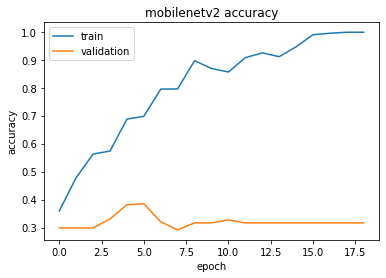

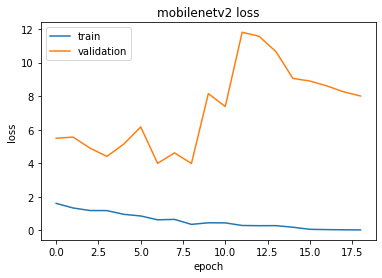

9/9 [==============================] - 1s 73ms/step
[[72 16  0]
 [93 14  0]
 [67 14  2]]
Acuracia balanceada na validacao: 0.324373108406438


In [ ]:
cria_e_treina_rede('mobilenetv2', train, val, callbacks=['earlystopping', 'reducelr'])

Found 1111 validated image filenames belonging to 3 classes.
Found 278 validated image filenames belonging to 3 classes.
29089792/29084464 [==============================] - 0s 0us/step
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet121 (Functional)     (None, 1024)              7037504   
_________________________________________________________________
dense_4 (Dense)              (None, 3)                 3075      
Total params: 7,040,579
Trainable params: 6,956,931
Non-trainable params: 83,648
_________________________________________________________________
Epoch 1/50
35/35 [==============================] - 35s 642ms/step - loss: 1.7571 - acc: 0.2916 - val_loss: 10.2879 - val_acc: 0.3777
Epoch 2/50
35/35 [==============================] - 16s 457ms/step - loss: 1.4020 - acc: 0.3686 - val_loss: 11.0276 - val_acc: 0.3237
Epoch 3/50
35/35 [=============================

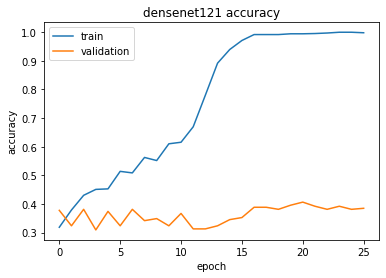

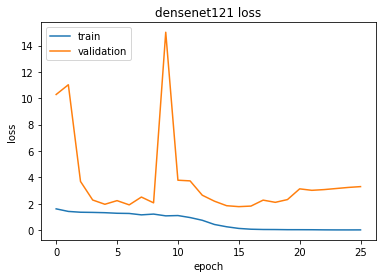

9/9 [==============================] - 2s 120ms/step
[[43 30 15]
 [53 47  7]
 [45 30  8]]
Acuracia balanceada na validacao: 0.34142474741787887


In [ ]:
cria_e_treina_rede('densenet121', train, val, callbacks=['earlystopping', 'reducelr'])

Found 1111 validated image filenames belonging to 3 classes.
Found 278 validated image filenames belonging to 3 classes.
51879936/51877672 [==============================] - 1s 0us/step
Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet169 (Functional)     (None, 1664)              12642880  
_________________________________________________________________
dense_5 (Dense)              (None, 3)                 4995      
Total params: 12,647,875
Trainable params: 12,489,475
Non-trainable params: 158,400
_________________________________________________________________
Epoch 1/50
35/35 [==============================] - 39s 692ms/step - loss: 1.8067 - acc: 0.3339 - val_loss: 8153.0034 - val_acc: 0.3165
Epoch 2/50
35/35 [==============================] - 20s 561ms/step - loss: 1.3858 - acc: 0.3644 - val_loss: 50.4579 - val_acc: 0.3165
Epoch 3/50
35/35 [========================

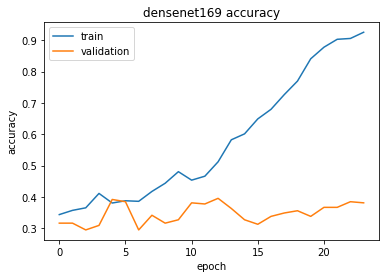

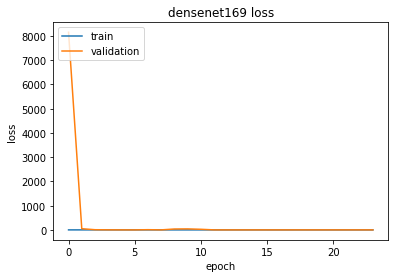

9/9 [==============================] - 3s 142ms/step
[[31 45 12]
 [40 54 13]
 [35 32 16]]
Acuracia balanceada na validacao: 0.3499055696021128


In [ ]:
cria_e_treina_rede('densenet169', train, val, callbacks=['earlystopping', 'reducelr'])

Found 1111 validated image filenames belonging to 3 classes.
Found 278 validated image filenames belonging to 3 classes.
74842112/74836368 [==============================] - 1s 0us/step
Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet201 (Functional)     (None, 1920)              18321984  
_________________________________________________________________
dense_6 (Dense)              (None, 3)                 5763      
Total params: 18,327,747
Trainable params: 18,098,691
Non-trainable params: 229,056
_________________________________________________________________
Epoch 1/50
70/70 [==============================] - 58s 513ms/step - loss: 1.8545 - acc: 0.3536 - val_loss: 235.9849 - val_acc: 0.3849
Epoch 2/50
70/70 [==============================] - 26s 373ms/step - loss: 1.4020 - acc: 0.3998 - val_loss: 4.3256 - val_acc: 0.3309
Epoch 3/50
70/70 [==========================

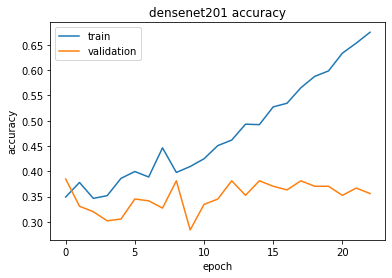

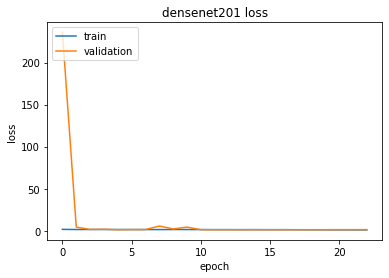

18/18 [==============================] - 4s 92ms/step
[[40 44  4]
 [38 64  5]
 [37 44  2]]
Acuracia balanceada na validacao: 0.35892422706970617


In [ ]:
cria_e_treina_rede('densenet201', train, val, callbacks=['earlystopping', 'reducelr'], batch_size=16)

Found 1111 validated image filenames belonging to 3 classes.
Found 278 validated image filenames belonging to 3 classes.
87916544/87910968 [==============================] - 1s 0us/step
Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 2048)              21802784  
_________________________________________________________________
dense_7 (Dense)              (None, 3)                 6147      
Total params: 21,808,931
Trainable params: 21,774,499
Non-trainable params: 34,432
_________________________________________________________________
Epoch 1/50
70/70 [==============================] - 25s 238ms/step - loss: 1.5978 - acc: 0.3413 - val_loss: 5023.5796 - val_acc: 0.3165
Epoch 2/50
70/70 [==============================] - 13s 181ms/step - loss: 1.4212 - acc: 0.3612 - val_loss: 107.9573 - val_acc: 0.3921
Epoch 3/50
70/70 [========================

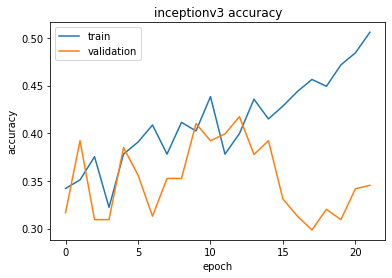

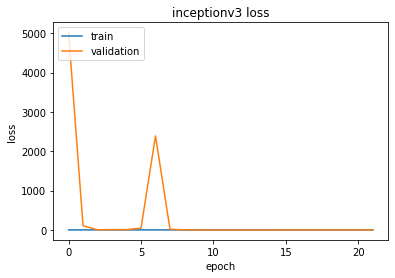

18/18 [==============================] - 2s 49ms/step
[[15 46 27]
 [13 65 29]
 [16 36 31]]
Acuracia balanceada na validacao: 0.3838083856240595


In [ ]:
cria_e_treina_rede('inceptionv3', train, val, callbacks=['earlystopping', 'reducelr'], batch_size=16)

Found 1111 validated image filenames belonging to 3 classes.
Found 278 validated image filenames belonging to 3 classes.
219062272/219055592 [==============================] - 2s 0us/step
Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_resnet_v2 (Functio (None, 1536)              54336736  
_________________________________________________________________
dense_8 (Dense)              (None, 3)                 4611      
Total params: 54,341,347
Trainable params: 54,280,803
Non-trainable params: 60,544
_________________________________________________________________
Epoch 1/50
35/35 [==============================] - 53s 979ms/step - loss: 1.6863 - acc: 0.3399 - val_loss: 122.6917 - val_acc: 0.3849
Epoch 2/50
35/35 [==============================] - 27s 774ms/step - loss: 1.4080 - acc: 0.3930 - val_loss: 2.6269 - val_acc: 0.3022
Epoch 3/50
35/35 [=========================

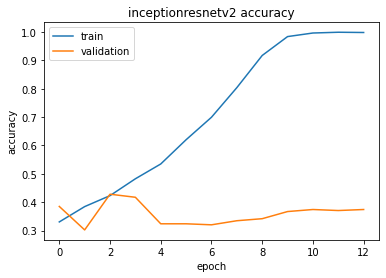

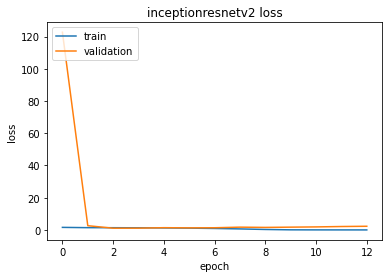

9/9 [==============================] - 4s 231ms/step
[[29 30 29]
 [23 50 34]
 [21 22 40]]
Acuracia balanceada na validacao: 0.4262542950049988


In [ ]:
cria_e_treina_rede('inceptionresnetv2', train, val, callbacks=['earlystopping', 'reducelr'])

Found 1111 validated image filenames belonging to 3 classes.
Found 278 validated image filenames belonging to 3 classes.
83689472/83683744 [==============================] - 1s 0us/step
Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Functional)        (None, 2048)              20861480  
_________________________________________________________________
dense_9 (Dense)              (None, 3)                 6147      
Total params: 20,867,627
Trainable params: 20,813,099
Non-trainable params: 54,528
_________________________________________________________________
Epoch 1/50
35/35 [==============================] - 38s 895ms/step - loss: 1.4317 - acc: 0.2899 - val_loss: 1.0987 - val_acc: 0.2950
Epoch 2/50
35/35 [==============================] - 26s 755ms/step - loss: 1.4039 - acc: 0.3322 - val_loss: 1.0984 - val_acc: 0.3849
Epoch 3/50
35/35 [=============================

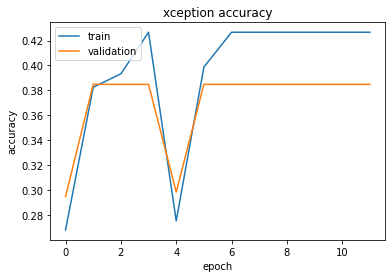

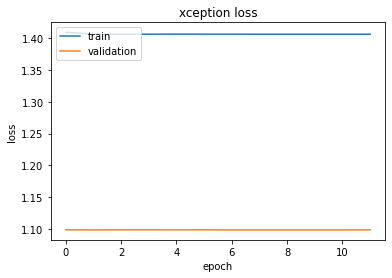

9/9 [==============================] - 2s 168ms/step
[[  0  88   0]
 [  0 107   0]
 [  0  83   0]]
Acuracia balanceada na validacao: 0.3333333333333333


In [ ]:
cria_e_treina_rede('xception', train, val, callbacks=['earlystopping', 'reducelr'])

Found 1111 validated image filenames belonging to 3 classes.
Found 278 validated image filenames belonging to 3 classes.
58892288/58889256 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 512)               14714688  
_________________________________________________________________
dense (Dense)                (None, 3)                 1539      
Total params: 14,716,227
Trainable params: 14,716,227
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
70/70 [==============================] - 64s 400ms/step - loss: 48.0533 - acc: 0.3455 - val_loss: 1.0984 - val_acc: 0.3849
Epoch 2/50
70/70 [==============================] - 24s 336ms/step - loss: 1.4044 - acc: 0.4199 - val_loss: 1.0985 - val_acc: 0.3849
Epoch 3/50
70/70 [==============================] - 2

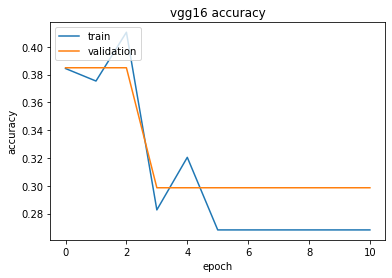

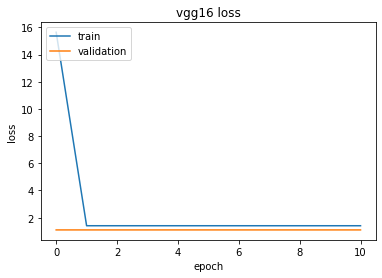

18/18 [==============================] - 2s 89ms/step
[[  0  88   0]
 [  0 107   0]
 [  0  83   0]]
Acuracia balanceada na validacao: 0.3333333333333333


In [ ]:
cria_e_treina_rede('vgg16', train, val, callbacks=['earlystopping', 'reducelr'], batch_size=16)

Found 1111 validated image filenames belonging to 3 classes.
Found 278 validated image filenames belonging to 3 classes.
80142336/80134624 [==============================] - 1s 0us/step
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 512)               20024384  
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 1539      
Total params: 20,025,923
Trainable params: 20,025,923
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
70/70 [==============================] - 30s 410ms/step - loss: 389.1929 - acc: 0.3363 - val_loss: 1.3219 - val_acc: 0.3849
Epoch 2/50
70/70 [==============================] - 28s 407ms/step - loss: 1.4461 - acc: 0.3086 - val_loss: 1.0997 - val_acc: 0.3165
Epoch 3/50
70/70 [==============================] 

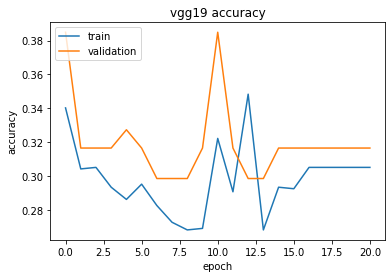

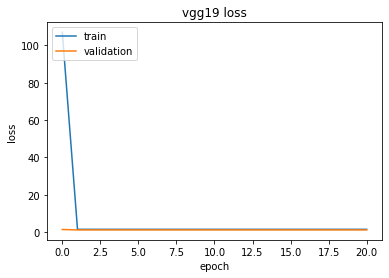

18/18 [==============================] - 2s 108ms/step
[[  0  88   0]
 [  0 107   0]
 [  0  83   0]]
Acuracia balanceada na validacao: 0.3333333333333333


In [ ]:
cria_e_treina_rede('vgg19', train, val, callbacks=['earlystopping', 'reducelr'], batch_size=16)

# Resultados

Tomando como base a tabela abaixo que sinalisa a acurácia balanceada em cada uma das redes analisadas, temos que a rede InceptionResNetV2 obteve a melhor acurácia balanceada com **42,63**. Em segundo lugar tivemos a EfficientNetB0 com 38,52. Dessa forma o consideraremos o InceptionResNetV2 como o nosso baseline.

O InceptionResNetV2 foi configurado com o earlystopping e com o Reduce learning rate que reduz a taxa de aprendizado quando não tem melhora na loss da validação.


| Rede             | Acurácia Balanceada na Validação|
| -----------------|-------------------:|
| ResNet50         | 32,74              |
| ResNet101        | 37,84              |
| ResNet152        | 37,89              |
| EfficientNetB0   | 38,52              |
| EfficientNetB1   | 36,94              |
| EfficientNetB2   | 33,01              |
| EfficientNetB3   | 38,37              |
| EfficientNetB4   | 37,87              |
| EfficientNetB5   | 33,58              |
| EfficientNetB6   | 33,71              |
| EfficientNetB7   | 35,00              |
| MobileNet        | 38,29              |
| MobileNetV2      | 32,44              |
| DenseNet121      | 34,14              |
| DenseNet169      | 34,99              |
| DenseNet201      | 35,89              |
| InceptionV3      | 38,38              |
| InceptionResNetV2| **42,63**          |
| Xception         | 33,33              |
| VGG16            | 33,33              |
| VGG19            | 33,33              |